In [ ]:
!pip install matplotlib-venn

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

def plot_confusion_mtx(matrix,num_classes):

  plt.figure(figsize=(10,8))
  ax= plt.subplot()
  cmap=sns.light_palette("blue")
  sns.heatmap(matrix, annot=True, ax = ax,fmt=".3f"); 
  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels');
  ax.set_title('Confusion Matrix');
  ax.xaxis.set_ticklabels([str(i) for i in range(num_classes)]); ax.yaxis.set_ticklabels([str(i) for i in range(num_classes)]);
  plt.show()

In [3]:
from keras.datasets import fashion_mnist
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
labels=["T-shirt/top","Trouser","Pullover","Dress","Coat",
        "Sandal","Shirt","Sneaker","Bag","Ankle boot"]

4423680/4422102 [==============================] - 0s 0us/step


Question 1: Download the fashion-MNIST dataset and plot 1 sample image for each class as shown in the grid below. Use "from keras.datasets import fashion_mnist" for getting the fashion mnist dataset.

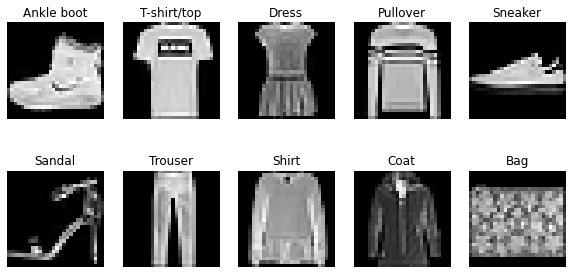

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5)) 

plottedClass =  [False for i in range(10)] 
count=0
for i in range(25):
    if  plottedClass[Y_train[i]]==False:
      plt.subplot(2,5,count+1).set_title(labels[Y_train[i]]) 
      plt.imshow(X_train[i],cmap='gray')
      plt.axis("off")
      plottedClass[Y_train[i]]=True
      count=count+1

plt.show()

**Backpropagation code stage1.**

In [5]:
import numpy as np

In [6]:
from sklearn.preprocessing import OneHotEncoder

#flatten the Xtrain and X_test
X_train=X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X_test=X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]))

#create one hot encoding of the labels
Y_train=OneHotEncoder().fit_transform(Y_train.reshape(-1,1)).toarray()
Y_test=OneHotEncoder().fit_transform(Y_test.reshape(-1,1)).toarray()


#normalizing the train data and test data...
X_train=X_train/255
X_test=X_test/255

In [7]:
class Activation:

  def Sigmoid(self,x):
    return 1/(1+np.exp(-x))

  def Softmax(self,x):
    numr=np.exp(x)
    return numr/sum(np.exp(x))

  def Relu(self,x):
    return 1

  def Tanh(self,x):
    numr=np.exp(x)-np.exp(-x)
    denom=np.exp(x)+np.exp(-x)
    return numr/denom

  def Derivative_Sigmoid(self,x):
    s=1/(1+np.exp(-x))
    return s*(1-s)

  def Derivative_Relu(self,x):
    return 1  

  def Derivative_Tanh(self,x):
    return 1-self.Tanh(x)**2

  def Linear(self,x):
    return x


In [8]:
class Loss:

  #Takes ypred as [[],[]] and y as [[],[]]
  def CategoricalCrossEntropy(self,ypred,y):
    
    class_idx=np.argmax(y,axis=1)
    cce_loss=0
    for i in range(len(class_idx)):
      cce_loss+=(-1)*np.log2(ypred[i][class_idx[i]])

    return cce_loss/len(ypred)


  def meansquarederror(self,ypred,y):

    #check for correct squared loss function
    return np.sum((ypred-y)**2)



In [9]:
class Layer:

  def __init__(self,num_inputs,num_neurons,activation,optimizer):
    
    self.num_inputs=num_inputs
    self.num_neurons=num_neurons
    self.activation=activation
    self.optimizer=optimizer

    self.W=np.random.randn(self.num_neurons,self.num_inputs)
    self.b=np.random.randn(self.num_neurons,)

    self.aL=0
    self.hL=0
    self.del_h=0
    self.del_a=0
    self.delW=0
    self.prev_Uw=0
    self.delb=0
    self.prev_Ub=0
  

  def Forward(self,h_L_1):
    
    self.aL=np.dot(self.W,h_L_1)+self.b

    if self.activation=="Relu":
      self.hL=Activation().Relu(self.aL)

    elif self.activation=="Tanh":
      self.hL=Activation().Tanh(self.aL)
    
    elif self.activation=="Softmax":
      self.hL=Activation().Softmax(self.aL)
    
    elif self.activation=="Linear":
      self.hL=Activation().Linear(self.aL)

    else:
      self.hL=Activation().Sigmoid(self.aL)

    
  def get_gradients(self,isoplayer,Y_hat,Y,prev_hL,nextW,next_del_a):
      
      #If it is the output layer...
      if isoplayer==1:

        if self.activation=='Softmax':
          for i in range(len(Y_hat)):
            self.del_h+=((-1/Y_hat[i][np.argmax(Y[i])])*Y[i])

          for i in range(len(Y_hat)):  
            self.del_a+=(Y_hat[i]-Y[i])
      
      #write the gradients formula for linear activation...
        elif self.activation == 'Linear':
          pass
        
        else:
          pass

      #if it is not the output layer..
      else:
        self.del_h=np.dot((nextW).T,next_del_a)

        #gradients wrt pre activation for different Activation function used..
        if self.activation=="Relu":
          self.del_a=(self.del_h)*(Activation().Derivative_Relu(self.aL))

        elif self.activation=="Tanh":
          self.del_a=(self.del_h)*(Activation().Derivative_Tanh(self.aL))
      
        else:
          self.del_a=(self.del_h)*(Activation().Derivative_Sigmoid(self.aL))

      self.delW=np.dot(self.del_a.reshape(-1,1),prev_hL.reshape(1,-1))
      self.delb=self.del_a

    
  def reset_gradients(self):
    
    self.del_h=0
    self.del_a=0
    self.delW=0
    self.delb=0

  

In [10]:
class IpLayer:

  def __init__(self,num_neurons):
    self.num_neurons=num_neurons
    self.hL=0

  def Forward(self,x):
    self.hL=x


In [11]:
class NN:

  def __init__(self,input_shape,num_hlayers,neurons,activations,optimizer,output_shape):

    self.input_shape=input_shape
    self.output_shape=output_shape
    self.num_hlayers=num_hlayers
    self.neurons=neurons
    self.HLAc=activations[0]
    self.OPAc=activations[1]
    self.optimizer=optimizer

    self.Layers=[]
    self.eta=1e-3
    self.gamma=0.9
    
    #create input layer
    self.Layers.append(IpLayer(self.input_shape))

    #hidden layers..
    for layer in range(1,self.num_hlayers+2):
      
      ip_shape=self.Layers[layer-1].num_neurons

      #output layer...
      if layer==self.num_hlayers+1:
         self.Layers.append(Layer(ip_shape,self.output_shape,self.OPAc,self.optimizer))
      
      else:
        self.Layers.append(Layer(ip_shape,self.neurons[layer-1],self.HLAc,self.optimizer))
  
  
  # <<<<<<FOR OTHER OPTIMIZERS ADJUST THIS FUNCTION>>>>>>> #
  def Do_one_Pass(self,X,Y):
    
    Y_hat=[]

    if self.optimizer=='Nestrov':
      #Get look aheads Wla and bla for each layer...
      for i in range(1,self.num_hlayers+2):
        self.Layers[i].W = self.Layers[i].W - self.gamma * self.Layers[i].prev_Uw
        self.Layers[i].b = self.Layers[i].b - self.gamma * self.Layers[i].prev_Ub
      
    #1.Do feed forward... and get Y_hat...
    for i in range(X.shape[0]):
      #get the data in input layer
      self.Layers[0].Forward(X[i])
      #pass the data to the hl+ol
      for j in range(1,self.num_hlayers+2):
        h_L_1=self.Layers[j-1].hL
        self.Layers[j].Forward(h_L_1)

      ypred=self.Layers[self.num_hlayers+1].hL
      Y_hat.append(ypred)
      
      

      #2 Do back propogation...
      for i in range(self.num_hlayers+1,0,-1):
        prev_hL=self.Layers[i-1].hL
        if i==self.num_hlayers+1:
          self.Layers[i].get_gradients(1,Y_hat,Y,prev_hL,0,0)
        else:
          next_W=self.Layers[i+1].W
          next_del_a=self.Layers[i+1].del_a
          self.Layers[i].get_gradients(0,Y_hat,Y,prev_hL,next_W,next_del_a)
      
      #3.Update parameters for each layer
      for i in range(1,self.num_hlayers+2):
        Uw_t = (self.gamma) * (self.Layers[i].prev_Uw) + (self.eta) * (self.Layers[i].delW)
        Ub_t = self.gamma * self.Layers[i].prev_Ub + (self.eta) * (self.Layers[i].delb)

        self.Layers[i].W = self.Layers[i].W - Uw_t
        self.Layers[i].b = self.Layers[i].b - Ub_t

        if self.optimizer=='Simple_GD':
          self.Layers[i].prev_Uw = 0.0
          self.Layers[i].prev_Ub = 0.0
        
        else:
          self.Layers[i].prev_Uw = Uw_t
          self.Layers[i].prev_Ub = Ub_t
        
      #4.reset the gradients..
      for i in range(1,self.num_hlayers+2):
        self.Layers[i].reset_gradients()
      
    elif self.optimizer=='RMSProp':
      beta=0.9
      eps=le-8
      #2.Do Feed forward 
      for i in range(X.shape[0]):
        #get the data in input layer
        self.Layers[0].Forward(X[i])
        #pass the data to the hl+ol
        for j in range(1,self.num_hlayers+2):
          h_L_1=self.Layers[j-1].hL
          self.Layers[j].Forward(h_L_1)

        ypred=self.Layers[self.num_hlayers+1].hL
        Y_hat.append(ypred)
    
      #3.Do backpropogation..

      for i in range(self.num_hlayers+1,0,-1):
        prev_hL=self.Layers[i-1].hL
        if i==self.num_hlayers+1:
          self.Layers[i].get_gradients(1,Y_hat,Y,prev_hL,0,0)
        else:
          next_W=self.Layers[i+1].W
          next_del_a=self.Layers[i+1].del_a
          self.Layers[i].get_gradients(0,Y_hat,Y,prev_hL,next_W,next_del_a)
        
      #4.Update W and b for each layer using new update rule...
      for i in range(1,self.num_hlayers+2):
        self.Layers[i].prev_Uw = beta * self.Layers[i].prev_Uw + (1-beta) * (self.Layers[i].delW.square)
        self.Layers[i].prev_Ub = beta * self.Layers[i].prev_Ub + (1-beta) * (self.Layers[i].delb.square)

        self.Layers[i].W = self.Layers[i].W - (self.eta/np.sqrt(self.Layers[i].prev_Uw+eps))*self.Layers[i].prev_Uw
        self.Layers[i].b = self.Layers[i].b - (self.eta/np.sqrt(self.Layers[i].prev_Ub+eps))*self.Layers[i].prev_Ub


      #5 reset the gradients and loss..
      for i in range(1,self.num_hlayers+2):
        self.Layers[i].reset_gradients()

  #takes complete X_train and Y_train and return the (n x 10) probability distribution.
  def Final_Prediction(self,X,Y):
    pred_whole=[]

    for i in range(X.shape[0]):
      #get the data in input layer
      self.Layers[0].Forward(X[i])
      #pass the data to the hl+ol
      for j in range(1,self.num_hlayers+2):
        h_L_1=self.Layers[j-1].hL
        self.Layers[j].Forward(h_L_1)

      ypred=self.Layers[self.num_hlayers+1].hL
      pred_whole.append(ypred)   

    return pred_whole  


  

**Training..**

In [17]:
#run the version of GD and returns (loss_for_each_epoch=[],final_prediction_probabilities)
class GD_Versions:

  #NN is after creating architecture...
  def __init__(self,NN,X,Y,epochs):

    self.NN=NN
    self.X=X
    self.Y=Y
    self.epochs=epochs

  def Batch_GD(self):

    loss_epoch=[]

    for i in range(self.epochs):

      #pass whole data 
      self.NN.Do_one_Pass(self.X,self.Y)
      
      ypred=self.NN.Final_Prediction(self.X,self.Y)
      loss_epoch.append(Loss().CategoricalCrossEntropy(ypred,self.Y))

      if i==self.epochs-1:
        return (ypred,loss_epoch)

  
  def SGD(self):
    loss_epoch=[]
    for i in range(self.epochs):

      n=self.X.shape[0]

      for dpi in range(n):
        self.NN.Do_one_Pass(self.X[dpi].reshape(1,-1),self.Y[dpi].reshape(1,-1))

      ypred=self.NN.Final_Prediction(self.X,self.Y)
      loss_epoch.append(Loss().CategoricalCrossEntropy(ypred,self.Y))

      if i==self.epochs-1:
        return (ypred,loss_epoch)


  def Mini_Batch(self,batch_size):
    n=self.X.shape[0]
    loss_epoch=[]
    for i in range(self.epochs):

      sidx = 0
      while sidx+batch_size <= n:
        self.NN.Do_one_Pass(self.X[sidx:sidx+batch_size],self.Y[sidx:sidx+batch_size])
        sidx+=batch_size
    
      if sidx!=n:
        self.NN.Do_one_Pass(self.X[sidx:n],self.Y[sidx:n])
    
      ypred=self.NN.Final_Prediction(self.X,self.Y)
      loss_epoch.append(Loss().CategoricalCrossEntropy(ypred,self.Y))

      if i==self.epochs-1:
        return (ypred,loss_epoch)


In [26]:
#considering this subset of data as train data..
X_sample=X_train[:4000]
Y_sample=Y_train[:4000]

arch1=NN(input_shape=784,num_hlayers=1,neurons=[64],activations=['Sigmoid','Softmax'],optimizer='RMSProp',output_shape=10)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


train accuracy
0.62075


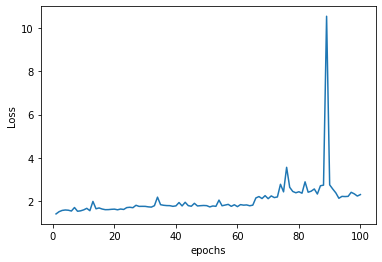

Test Accuracy


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


0.6085


In [32]:
epochs=100
gd_v = GD_Versions(arch1,X_sample,Y_sample,epochs)
pred,loss_epoch=gd_v.Mini_Batch(16)
print("train accuracy")
print(np.sum(np.argmax(pred,axis=1)==np.argmax(Y_sample,axis=1))/len(Y_sample))

plt.plot(np.arange(1,epochs+1),loss_epoch)
plt.xlabel("epochs");plt.ylabel("Loss");plt.show()

print("Test Accuracy")
predtest=arch1.Final_Prediction(X_test,Y_test)
print(np.sum(np.argmax(predtest,axis=1)==np.argmax(Y_test,axis=1))/len(Y_test))


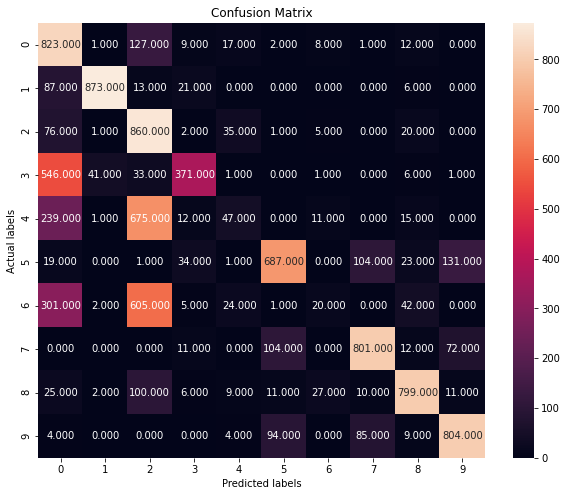

              precision    recall  f1-score   support

 T-shirt/top       0.39      0.82      0.53      1000
     Trouser       0.95      0.87      0.91      1000
    Pullover       0.36      0.86      0.50      1000
       Dress       0.79      0.37      0.50      1000
        Coat       0.34      0.05      0.08      1000
      Sandal       0.76      0.69      0.72      1000
       Shirt       0.28      0.02      0.04      1000
     Sneaker       0.80      0.80      0.80      1000
         Bag       0.85      0.80      0.82      1000
  Ankle boot       0.79      0.80      0.80      1000

    accuracy                           0.61     10000
   macro avg       0.63      0.61      0.57     10000
weighted avg       0.63      0.61      0.57     10000



In [33]:
cf=confusion_matrix(y_true=np.argmax(Y_test,axis=1),y_pred=np.argmax(predtest,axis=1))
plot_confusion_mtx(cf,10)
print(classification_report(y_true=np.argmax(Y_test,axis=1), y_pred=np.argmax(predtest,axis=1), target_names=labels))

In [ ]:
'''elif self.optimizer=='Moment_Based':

      #1.Do feed forward...
      for i in range(X.shape[0]):
        #get the data in input layer
        self.Layers[0].Forward(X[i])
        #pass the data to the hl+ol
        for j in range(1,self.num_hlayers+2):
          h_L_1=self.Layers[j-1].hL
          self.Layers[j].Forward(h_L_1)

        ypred=self.Layers[self.num_hlayers+1].hL
        Y_hat.append(ypred)

      #2 Do back propogation...
      for i in range(self.num_hlayers+1,0,-1):
        prev_hL = self.Layers[i-1].hL
        if i==self.num_hlayers+1:
          self.Layers[i].get_gradients(1,Y_hat,Y,prev_hL,0,0)
        else:
          next_W = self.Layers[i+1].W
          next_del_a = self.Layers[i+1].del_a
          self.Layers[i].get_gradients(0,Y_hat,Y,prev_hL,next_W,next_del_a)
        
      #3update parameters for each layer...
      for i in range(1,self.num_hlayers+2):

        Uw_t = self.gamma * self.Layers[i].prev_Uw + self.eta*self.Layers[i].delW
        Ub_t = self.gamma*self.Layers[i].prev_Ub + self.eta*self.Layers[i].delb
        
        self.Layers[i].W = self.Layers[i].W - Uw_t
        self.Layers[i].b = self.Layers[i].b - Ub_t

        self.Layers[i].prev_Uw = Uw_t
        self.Layers[i].prev_Ub = Ub_t

      #4reset the gradients and loss...
      for i in range(1,self.num_hlayers+2):
        self.Layers[i].reset_gradients()

#---------------------------------------------------------------------------------------#

    elif self.optimizer=='Nestrov':

      #1.Get look aheads Wla and bla for each layer..
      for i in range(1,self.num_hlayers+2):
        self.Layers[i].W = self.Layers[i].W - self.gamma * self.Layers[i].prev_Uw
        self.Layers[i].b = self.Layers[i].b - self.gamma * self.Layers[i].prev_Ub

      #2.Feed forward the data to get the gradients at this wlookahead and blookahead
    
      for i in range(X.shape[0]):
        #get the data in input layer
        self.Layers[0].Forward(X[i])
        #pass the data to the hl+ol
        for j in range(1,self.num_hlayers+2):
          h_L_1=self.Layers[j-1].hL
          self.Layers[j].Forward(h_L_1)

        ypred=self.Layers[self.num_hlayers+1].hL
        Y_hat.append(ypred)
    
      #3.Do backpropogation..

      for i in range(self.num_hlayers+1,0,-1):
        prev_hL=self.Layers[i-1].hL
        if i==self.num_hlayers+1:
          self.Layers[i].get_gradients(1,Y_hat,Y,prev_hL,0,0)
        else:
          next_W=self.Layers[i+1].W
          next_del_a=self.Layers[i+1].del_a
          self.Layers[i].get_gradients(0,Y_hat,Y,prev_hL,next_W,next_del_a)
        
      #4.Update W and b for each layer using new update rule...
      for i in range(1,self.num_hlayers+2):
        Uw_t = self.gamma * self.Layers[i].prev_Uw + (self.eta) * (self.Layers[i].delW)
        Ub_t = self.gamma * self.Layers[i].prev_Ub + (self.eta) * (self.Layers[i].delb)

        self.Layers[i].W = self.Layers[i].W - Uw_t
        self.Layers[i].b = self.Layers[i].b - Ub_t

        self.Layers[i].prev_Uw = Uw_t
        self.Layers[i].prev_Ub = Ub_t

      #5 reset the gradients and loss..
      for i in range(1,self.num_hlayers+2):
        self.Layers[i].reset_gradients()

#---------------------------------------------------------------------------------------#
    elif self.optimizer=='RMSProp':
      beta=0.9
      eps=le-8
      #2.Do Feed forward 
      for i in range(X.shape[0]):
        #get the data in input layer
        self.Layers[0].Forward(X[i])
        #pass the data to the hl+ol
        for j in range(1,self.num_hlayers+2):
          h_L_1=self.Layers[j-1].hL
          self.Layers[j].Forward(h_L_1)

        ypred=self.Layers[self.num_hlayers+1].hL
        Y_hat.append(ypred)
    
      #3.Do backpropogation..

      for i in range(self.num_hlayers+1,0,-1):
        prev_hL=self.Layers[i-1].hL
        if i==self.num_hlayers+1:
          self.Layers[i].get_gradients(1,Y_hat,Y,prev_hL,0,0)
        else:
          next_W=self.Layers[i+1].W
          next_del_a=self.Layers[i+1].del_a
          self.Layers[i].get_gradients(0,Y_hat,Y,prev_hL,next_W,next_del_a)
        
      #4.Update W and b for each layer using new update rule...
      for i in range(1,self.num_hlayers+2):
        self.Layers[i].prev_Uw = beta * self.Layers[i].prev_Uw + (1-beta) * (self.Layers[i].delW.square)
        self.Layers[i].prev_Ub = beta * self.Layers[i].prev_Ub + (1-beta) * (self.Layers[i].delb.square)

        self.Layers[i].W = self.Layers[i].W - (self.eta/np.sqrt(self.Layers[i].prev_Uw+eps))*self.Layers[i].prev_Uw
        self.Layers[i].b = self.Layers[i].b - (self.eta/np.sqrt(self.Layers[i].prev_Ub+eps))*self.Layers[i].prev_Ub


      #5 reset the gradients and loss..
      for i in range(1,self.num_hlayers+2):
        self.Layers[i].reset_gradients()
#---------------------------------------------------------------------------------------#   
    elif self.optimizer=='Nadam':
      pass
    
    else:
      pass'''